# Text generation with a bidirectional LSTM

Today we are looking at how to use a bidirectional Long Short-Term Memory (LSTM) network to generate text. The machine learning library **Tensorflow** is used in this notebook.

## What is an LSTM

An LSTM (Long Short-Term Memory) network is a type of RNNs designed to handle long-term dependencies more effectively than traditional RNNs. It utilizes specialized memory cells to retain and retrieve information over extended sequences, making it ideal for tasks like text generation where understanding context is crucial. In text generation, LSTMs can learn complex patterns within variable-length sequences of text documents, resulting in more coherent and contextually relevant output compared to simpler models like Markov language models.


## The implementation

First we import a text tokenizer to *(drum roll)*... tokenize the text. Why do we need to do this? and what is a corpus? Answer these questions as a written documentation on the code. Print some variables for more understanding.

In [2]:
# !pip install tensorflow

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer()
data = open("input.txt", encoding="utf-8").read()
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+1
print(total_words)

1202


In [5]:
corpus[:5]

['the attention mechanism is a vital component in artificial neural networks, particularly in the domain of deep learning and natural language processing (nlp). it enables models to focus on specific parts of input data while making predictions or generating output. initially popularized in the context of machine translation tasks, the attention mechanism has since found widespread applications in various other fields, including image captioning, speech recognition, and sentiment analysis.',
 '',
 'at its core, the attention mechanism allows neural networks to dynamically weigh the importance of different elements within the input sequence. this weighting process enables the model to selectively attend to relevant information, effectively enhancing its ability to understand and process complex data. in the context of machine translation, for example, the attention mechanism enables the model to align source and target language sequences more accurately, resulting in improved translatio

## Setting up Input Data for Sequential-Pattern Learning

To allow the LSTM to learn the sequential patterns and dependencies present in the text data, the input needs to be presented to the network in a form of n-gram sequences. For example, the sentence "I am studying in Deggendorf" should be turned into ["I", "I am", "I am studying", "I am studying at", "I am studying in Deggendorf"]. The following block does just that.

In [6]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [7]:
input_sequences[:5]

[[1, 2], [1, 2, 27], [1, 2, 27, 8], [1, 2, 27, 8, 7], [1, 2, 27, 8, 7, 528]]

## Challenge

If the input list is ["I", "I am", "I am studying", "I am studying at", "I am studying in Deggendorf"] (but tokenized of course), the input items are of different lengths. However, the network needs to be trained with fixed input length.

Complete the following block to pad the items into the same length (i.e., to the max length of input sequences).

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre'))
print(max_sequence_length)

115


## Setting The Target Output

During training, the LSTM model learns to predict the next token (label) based on the context provided by the input sequences (predictors). By iteratively adjusting its internal parameters through backpropagation, the model aims to minimize the categorical cross-entropy loss between its predictions and the actual labels.

* The predictors represent the input sequences used for training the LSTM, providing context for predicting the next token. 
* Labels are the target tokens to predict. 

In [16]:
import tensorflow.keras.utils as keras_utils
from pprint import pprint 

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = keras_utils.to_categorical(label, num_classes=total_words)
pprint(input_sequences[5])
print()
pprint(predictors[5])
pprint(label[5])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   2,  27,   8,   7, 528, 529], dtype=int32)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## The Model

The following block presents a sequential model with a unidirectional LSTM stacked on top of a bidirectional LSTM.

* If a tokenized input sequence is [1, 2, 3], does the +1 increment mean something? Hint: this is one of the reasons behind adding a word embedding layer.
* A bidirectional LSTM with 150 memory units is added. Why 150? and why is `return_sequences=True`? 
* Before adding a unidirectional LSTM on top of the bidirectional one, a `Dropout` layer is placed. Why?
* Two `Dense` layers are added after the unidirectional LSTM: one is halved in neuron numbers, with a ReLU activation, and a regulizer; the other is set up with softmax activation. Explain roughly and shortly for each the reason behind their use and setup.



In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers


model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dense(int(total_words/2), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Explainations

1. **Tokenized Input Sequence and +1 Increment**:
   - The +1 increment in tokenized input sequences doesn't directly mean anything; it's a placeholder indicating token IDs. Adding a word embedding layer helps by converting these token IDs into dense vectors, providing meaningful representations.

2. **Bidirectional LSTM with 150 Memory Units and `return_sequences=True`**:
   - **Why 150?**: This is a design choice, balancing computational efficiency and model capacity.
   - **`return_sequences=True`**: This is set to pass the output sequences of all time steps to the next layer, which is useful for stacking multiple LSTMs.

3. **Dropout Layer before Unidirectional LSTM**:
   - The Dropout layer helps prevent overfitting by randomly setting a fraction of input units to zero during training, promoting generalization.

4. **Dense Layers after Unidirectional LSTM**:
   - **First Dense Layer**: It has half the neurons (`total_words/2`) with ReLU activation and an L2 regularizer to reduce overfitting and introduce non-linearity.
   - **Second Dense Layer**: This layer uses softmax activation to convert the final output into a probability distribution, suitable for classification tasks like predicting the next word in a sequence.

## Training

The model is simply fit with the inputs and their expected outputs to be trained. 

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - accuracy: 0.0416 - loss: 8.0584
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 278ms/step - accuracy: 0.0511 - loss: 6.3734
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.0561 - loss: 5.9906
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.0528 - loss: 5.9009
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.0481 - loss: 5.8076
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.0533 - loss: 5.7478
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.0445 - loss: 5.7071
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.0611 - loss: 5.5789
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.0548 - loss: 5.5527
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 286ms/step - accuracy: 0.0595 - loss: 5.4717
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.0613 - loss: 5.4319
Epoch 12

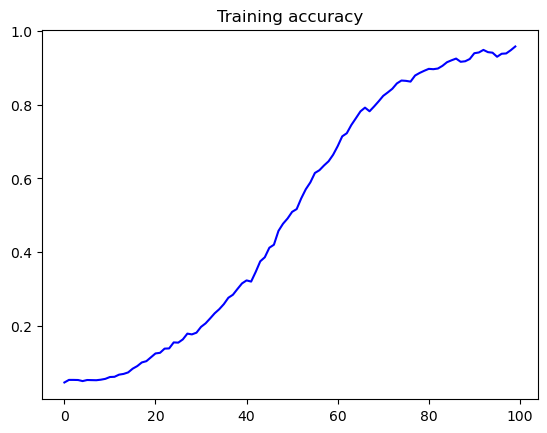

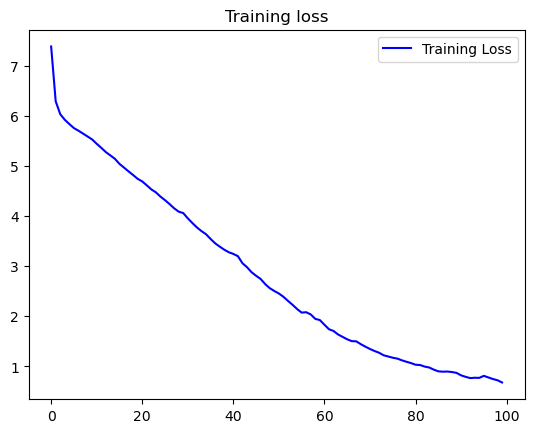

In [18]:
history = model.fit(predictors, label, epochs=100, verbose=1)

import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()


## Generating Text

Fill in the missing variables in the following block and let the model generate some words. Play with the previous parameters (training epochs, memory units, removing the unidirectional LSTM or any additional layer,...) and try to spot the deviations.

In [7]:
seed_text = " all you need "
next_words = 200

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)
    predicted_class = np.argmax(predicted_probabilities)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

 all you need  learning to control values 2022 speech arxiv 2304 07235 07 research 1987 iccv 2018 additional 1 cv terms in cognition foundations we 02 03 arxiv 1807 06521 cs cv language and language step arxiv 1709 01507 doi 10 1109 cvpr 2018 00745 isbn 978 1 5386 6420 9 s2cid 206597034 12 cv 978 attention with step by enables the neural head 2019 because a figures determined in transformers architectures within practice the attention weights express this treatment in long much effort has gone into understand attention further by studying their roles in focused settings such as in context learning 9 masked language tasks 10 stripped down transformers 11 bigram statistics 12 pairwise convolutions 13 and arithmetic factoring 14 isbn 978 1 7281 4803 8 s2cid 118673006 isbn isbn 978 1 7281 4803 8 s2cid 118673006 isbn isbn 978 1 7281 4803 8 s2cid 118673006 multimodal multi head convolutional attention with various kernel sizes for medical image super resolution recognition and sentiment anal

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers


model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(100, return_sequences=True))) # adjusted layer to 100 hiden stats
model.add(Dropout(0.2))
model.add(LSTM(100))  # adjusted layer to 100 hiden stats
model.add(Dense(int(total_words/2), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(int(total_words/3), activation='relu'))  # added new layer
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.0337 - loss: 7.6883
Epoch 2/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0541 - loss: 6.2674
Epoch 3/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.0553 - loss: 5.9667
Epoch 4/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.0556 - loss: 5.8867
Epoch 5/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0562 - loss: 5.7719
Epoch 6/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.0547 - loss: 5.7117
Epoch 7/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.0512 - loss: 5.6951
Epoch 8/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.0595 - loss: 5.5602
Epoch 9/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.0570 - loss: 5.6028
Epoch 10/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.0597 - loss: 5.4205
Epoch 11/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.0570 - loss: 5.4158
Epoch 12

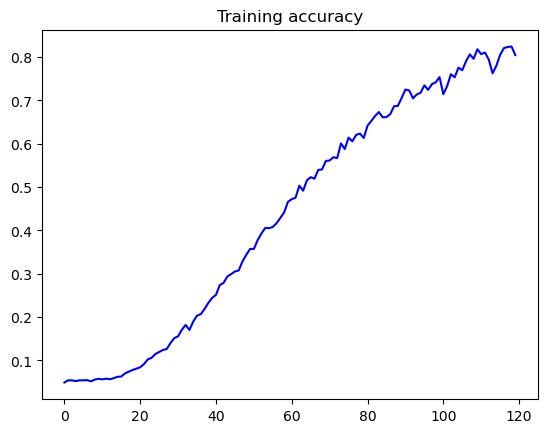

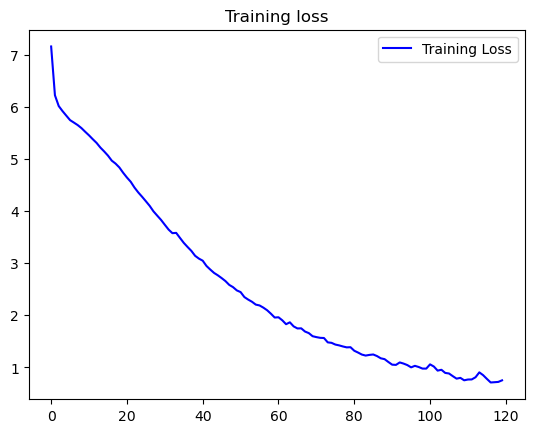

In [21]:
history1 = model.fit(predictors, label, epochs=120, verbose=1)

import matplotlib.pyplot as plt
acc = history1.history['accuracy']
loss = history1.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [22]:
seed_text = " all you need "
next_words = 250

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)
    predicted_class = np.argmax(predicted_probabilities)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

 all you need  with of another neural network through specific element of the hidden outputs of recurrent neural networks recurrent neural networks favor more recent information contained in words at the end of a sentence while information earlier in the sentence is expected to be attenuated attention allows the calculation of the hidden representation of a token equal access to any part of a sentence directly rather than only through the previous hidden state in neural computers and a resulting in the last english word and martin iccv take of transformers learns 100 includes finally they complex data sized in each step soft the turing machines 4 5 6 7 8 94 2022 03 12 perceiver has perception key pretraining encoder decoder 100 are symmetric additional for its sum of as a registered english word use of they representation the recurrent networks convolutional machine that could called aime occurs and remain frozen afterwards brock 68053 0 262 68053 0 262 68053 0 262 68053 0 262 68053 0 